### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import Resize, ToTensor, Normalize
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'



/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/data'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    Resize((224,336)),  # Resize to 224x336
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset

In [3]:
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


### Visualize first

Visualizing data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]


/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

Input image shape: (224, 336, 3), min: 0.0, max: 1.0
Label image shape: (224, 336), unique values: [-100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87
  -86  -85  -84  -83  -82  -81  -80  -79  -78  -76  -75  -74  -73  -72
  -71  -70  -69  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59  -58
  -56  -55  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45  -43  -42
  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31  -30  -29  -28
  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17  -16  -15  -14
  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0
    1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   37   38   39   40   41   42   43   44
   45   46   47   48   49   50   51   52   53   54   55   56   59   61
   63   64   65   67   68   69   73   75   77   78   81]
Input image shape: (224, 336, 3), min: 0.0, max: 1.0
Label imag

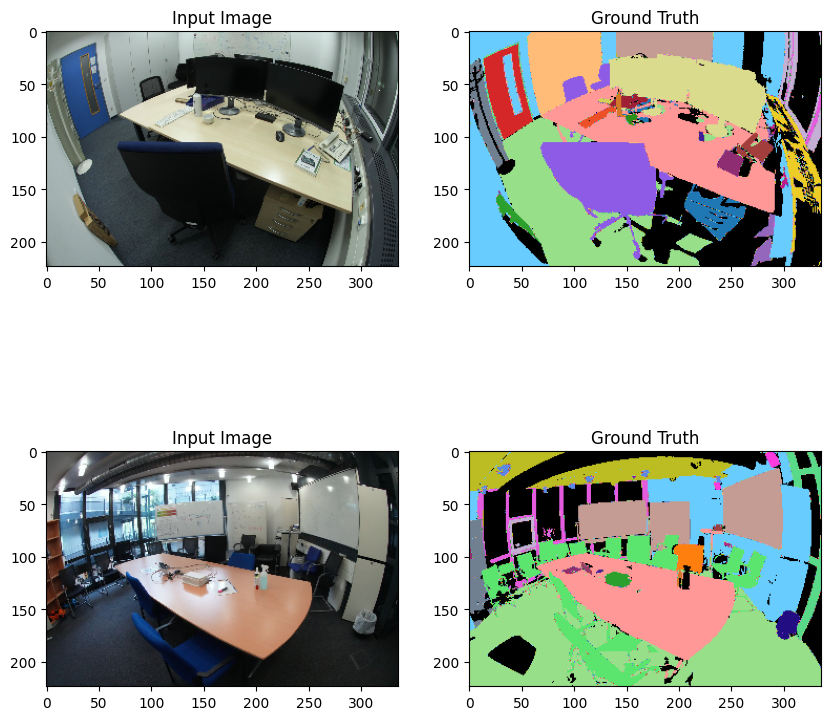

In [4]:
# Visualize data from the dataloader before training
print("Visualizing data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.networks.nn_2d_dino import DINOv2_Segmentation

# # Instantiate the model and move it to the device: MobileNetV3_Segmentation
# model = MobileNetV3_Segmentation(num_classes=101).to(device)

# Instantiate the model and move it to the device: Dinov2
model = DINOv2_Segmentation(num_classes=100).to(device)


# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')

# Clear GPU cache
torch.cuda.empty_cache()




Using cache found in /home/lukas/.cache/torch/hub/facebookresearch_dinov2_main
/home/lukas/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/lukas/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/lukas/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


### Load the latest

In [6]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

# Load latest checkpoint if available
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch}")


### Train loop

In [7]:
# Training loop
num_epochs = 200
save_interval = 5  # Save a checkpoint every 5 epochs

for epoch in range(start_epoch, num_epochs):

    model.train()
    running_loss = 0.0
    for i, images in enumerate(train_loader):
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask = (labels >= 100) | (labels < 0)
        labels[invalid_mask] = IGNORE_INDEX
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Ensure the shapes match before calculating the loss
        if outputs.shape[-2:] != labels.shape[-2:]:
            outputs = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
        
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    # Log training loss to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            inputs = images['image'].to(device)
            labels = images['label'].to(device)
            
            # Identify invalid labels and set them to IGNORE_INDEX
            invalid_mask = (labels >= 100) | (labels < 0)
            labels[invalid_mask] = IGNORE_INDEX
            
            outputs = model(inputs)
            
            # Ensure the shapes match before calculating the loss
            if outputs.shape[-2:] != labels.shape[-2:]:
                outputs = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {epoch_val_loss}")

    # Log validation loss to TensorBoard
    writer.add_scalar('Validation Loss', epoch_val_loss, epoch)

    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()

/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


Epoch [1/200], Loss: 3.1427206844091415
Validation Loss: 3.0115755796432495
Epoch [2/200], Loss: 2.775960236787796
Validation Loss: 3.02674663066864
Epoch [3/200], Loss: 2.680592566728592
Validation Loss: 2.9766242504119873
Epoch [4/200], Loss: 2.7851187586784363
Validation Loss: 2.99917733669281
Epoch [5/200], Loss: 2.707256108522415
Validation Loss: 2.7171709537506104
Epoch [6/200], Loss: 2.673650562763214
Validation Loss: 3.1202008724212646
Epoch [7/200], Loss: 2.7159684896469116
Validation Loss: 2.894109010696411
Epoch [8/200], Loss: 2.665252238512039
Validation Loss: 3.082117795944214


KeyboardInterrupt: 

### Inference and visualizations

Label shape: torch.Size([4, 224, 336]), unique values: tensor([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,  -89,
         -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,  -78,  -77,
         -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,  -67,  -66,  -65,
         -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,
         -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,
         -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,  -30,  -29,
         -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,  -19,  -18,  -17,
         -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,
          -4,   -3,   -2,   -1,    0,    1,    2,    3,    4,    5,    6,    7,
           8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
          20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
          32,   33,   34,   35,   36,   37,   38,   39,   40,   4

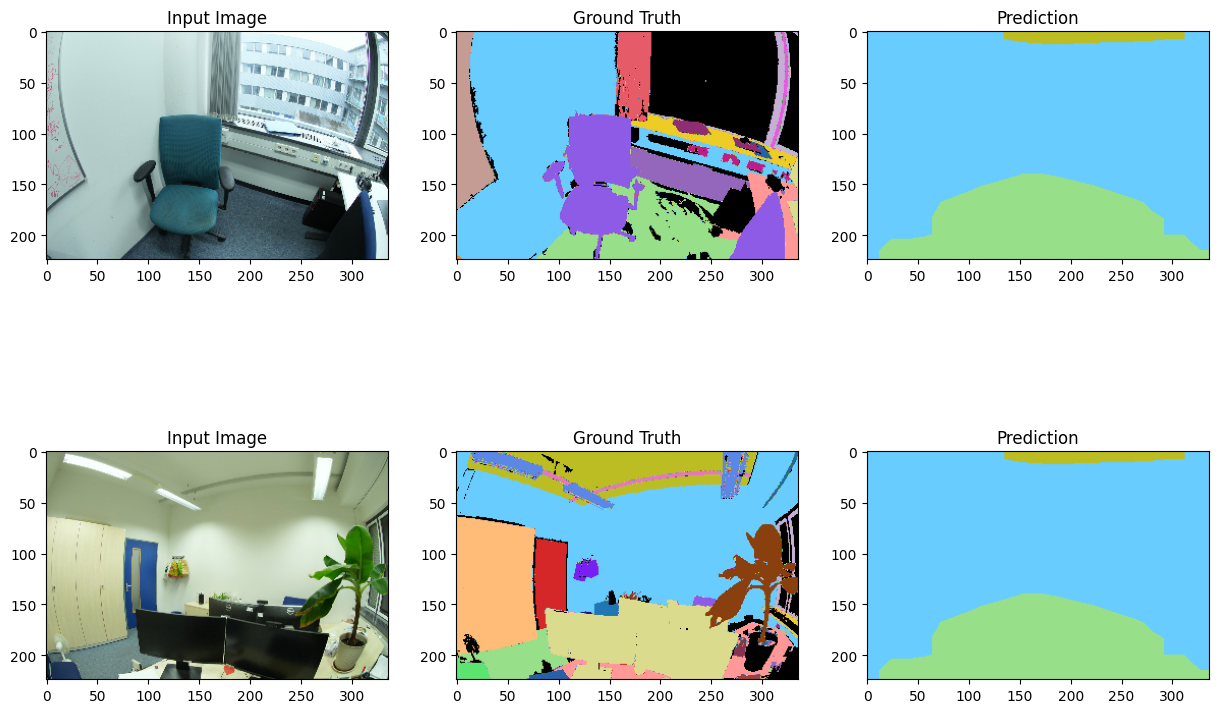

In [8]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_5.pth.tar')
inputs, labels, predictions = inference(model, train_loader, device, num_samples=2)
visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')